# Social Network Analysis of Exodus 20.22-23.33
In this notebook are collected all the tests used in the study. Almost all of them were taken from the primary source: https://github.com/ch-jensen/SNA


In [1]:
import collections
import os
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from scipy.ndimage import uniform_filter1d
from scipy.cluster.hierarchy import linkage, dendrogram
import forceatlas2
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from node2vec import Node2Vec

In [3]:
BASE_DIR = os.getcwd()
data_path = os.path.join(BASE_DIR, "Ex20.22-23.33.edges.Static.xlsx")
data_path_lev = os.path.join(BASE_DIR, "Lev17-26.edges.Static.xlsx")
data = pd.read_excel(data_path)

## Semantic roles

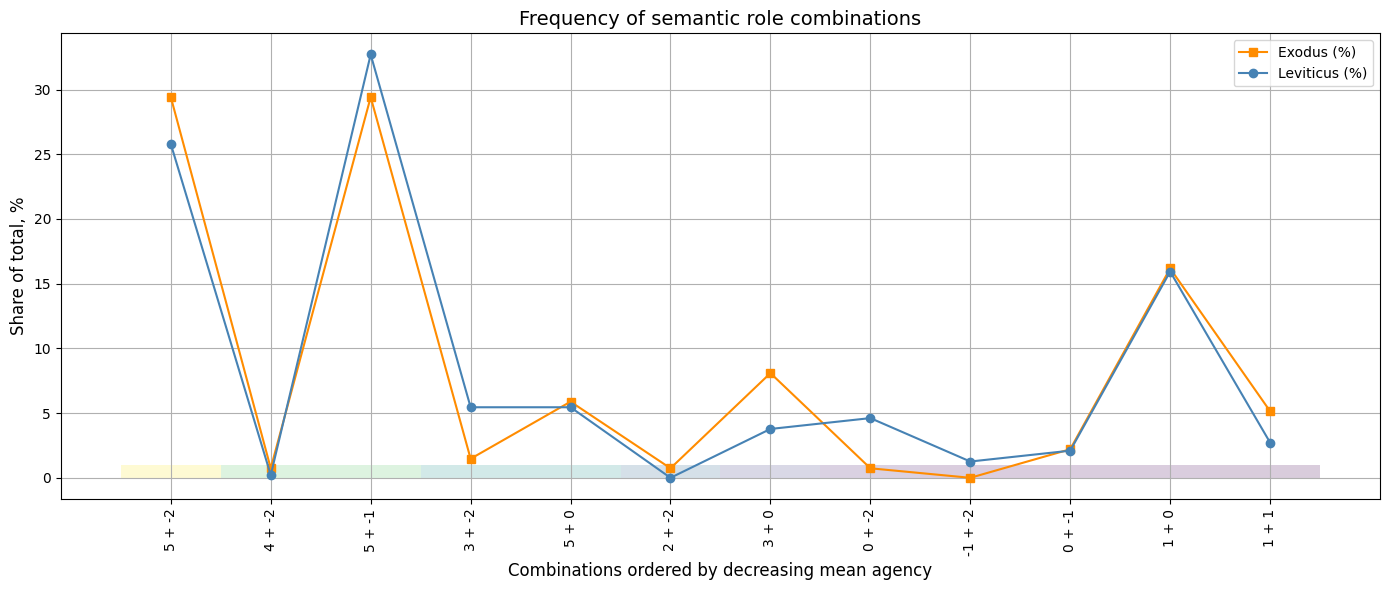

In [4]:
import matplotlib.patches as patches

exodus_df = pd.read_excel(data_path)
leviticus_df = pd.read_excel(data_path_lev)

exodus_df["Combination"] = exodus_df["Source_agency"].astype(str) + " + " + exodus_df["Target_agency"].astype(str)
leviticus_df["Combination"] = leviticus_df["Source_agency"].astype(str) + " + " + leviticus_df["Target_agency"].astype(str)

exodus_counts = exodus_df["Combination"].value_counts().reset_index()
exodus_counts.columns = ["Combination", "Exodus"]

leviticus_counts = leviticus_df["Combination"].value_counts().reset_index()
leviticus_counts.columns = ["Combination", "Leviticus"]

merged_df = pd.merge(exodus_counts, leviticus_counts, on="Combination", how="outer").fillna(0)

merged_df["Exodus"] = merged_df["Exodus"].astype(int)
merged_df["Leviticus"] = merged_df["Leviticus"].astype(int)

merged_df["Source_agency"] = merged_df["Combination"].str.extract(r"^(\-?\d+)", expand=False).astype(int)
merged_df["Target_agency"] = merged_df["Combination"].str.extract(r"\+ (\-?\d+)", expand=False).astype(int)

merged_df["Agency_Diff_Sq"] = (merged_df["Source_agency"] - merged_df["Target_agency"]) ** 2

total_exodus = merged_df["Exodus"].sum()
total_leviticus = merged_df["Leviticus"].sum()

merged_df["Exodus_pct"] = merged_df["Exodus"] / total_exodus * 100
merged_df["Leviticus_pct"] = merged_df["Leviticus"] / total_leviticus * 100

merged_sorted = merged_df.sort_values(by="Agency_Diff_Sq", ascending=False).reset_index(drop=True)

norm = plt.Normalize(merged_sorted["Agency_Diff_Sq"].min(), merged_sorted["Agency_Diff_Sq"].max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(14, 6))

for i, diff in enumerate(merged_sorted["Agency_Diff_Sq"]):
    color = cmap(norm(diff))
    ax.add_patch(
        patches.Rectangle(
            (i - 0.5, 0), 1, ax.get_ylim()[1],  
            facecolor=color,
            alpha=0.2,
            zorder=0
        )
    )

ax.plot(merged_sorted.index, merged_sorted["Exodus_pct"], label="Exodus (%)", color="darkorange", marker="s")
ax.plot(merged_sorted.index, merged_sorted["Leviticus_pct"], label="Leviticus (%)", color="steelblue", marker="o")

ax.set_xticks(merged_sorted.index)
ax.set_xticklabels(merged_sorted["Combination"], rotation=90)
ax.set_ylabel("Share of total, %", fontsize=12)
ax.set_xlabel("Combinations ordered by decreasing mean agency", fontsize=12)
ax.set_title("Frequency of semantic role combinations", fontsize=14)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Semantic_roles.png', dpi=500, bbox_inches='tight')
plt.show()

## Visualization


In [5]:
G = nx.MultiGraph()
nx.to_numpy_matrix = nx.to_numpy_array

for n, row in data.iterrows():  
    G.add_edge(row.Source, row.Target)
    
pos = { i : (random.random(), random.random()) for i in G.nodes()}
l = forceatlas2.forceatlas2_networkx_layout(G, pos, niter=2000, gravity=30, scalingRatio=2.0)

In [6]:
weight = collections.Counter(G.edges())

for u, v, d in G.edges(data=True):
    d['weight'] = weight[u, v]

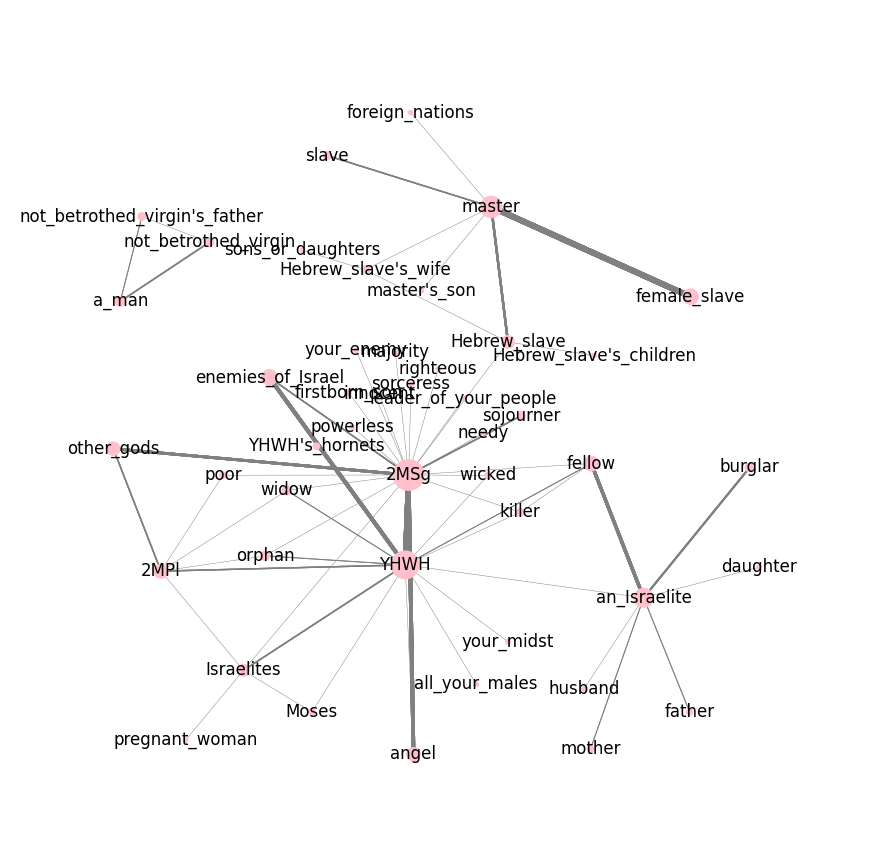

In [7]:
plt.figure(figsize = (11,11))

nx.draw_networkx(G, l, node_color='pink', node_size=[n[1]*10 for n in G.degree()], 
                 edge_color='grey', width=[d['weight']/3 for _, _, d in G.edges(data=True)])

plt.axis('off')
plt.margins(x=0.1, y=0.1)

plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Vizualization_network.png', dpi=500, bbox_inches='tight')
plt.show()


Number of nodes and edges

In [ ]:
print(f'Nodes: {len(G.nodes())}\nEdges: {len(G.edges())}')

Nodes: 46
Edges: 136


Dictionary of all nodes

In [ ]:
rel_dict = {}

for n in G.nodes():
    rel_dict[n] = len(nx.ego_graph(G, n, undirected=True))
    
pd.DataFrame([rel_dict]).T.sort_values(by=0, ascending=False)

,0
2MSg,23
YHWH,16
an_Israelite,8
2MPl,7
master,7
Israelites,6
Hebrew_slave,5
fellow,5
enemies_of_Israel,4
Hebrew_slave's_wife,4


Once our graph has been created, we can proceed to its metric analysis:

### Cohesion and network density


In [ ]:
G1 = nx.Graph()

for n, row in data.iterrows():  
    G1.add_edge(row.Source, row.Target)

In [ ]:
print(f'Nodes: {len(G1.nodes())}\nEdges: {len(G1.edges())}')

Nodes: 46
Edges: 63


In [ ]:
nx.density(G1)

0.06086956521739131

In [ ]:
degree = G.degree()
sum_degree = sum(dict(degree).values())
print(f'Average degree: {sum_degree/len(G.nodes())}')

Average degree: 5.913043478260869


In [ ]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():  
    G.add_edge(row.Source, row.Target)

indegree_cum_norm (%): std diff=10.665, range diff=41.304, mean abs resid=2.126, RMS resid=4.324
outdegree_cum_norm (%): std diff=5.966, range diff=23.913, mean abs resid=1.449, RMS resid=2.775
Average degree: 5.913043478260869


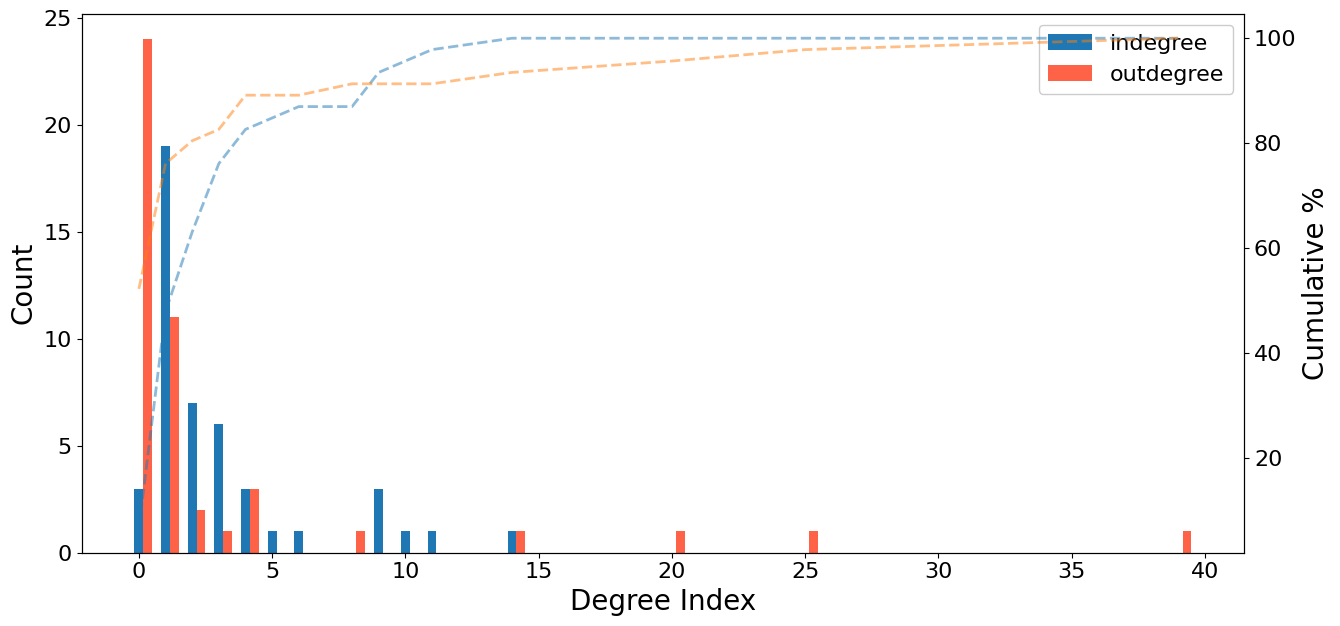

In [ ]:

outdegree_sequence = collections.Counter(sorted([d for n, d in G.out_degree()], reverse=True))
indegree_sequence = collections.Counter(sorted([d for n, d in G.in_degree()], reverse=True))

outdegree_df = pd.DataFrame(outdegree_sequence, index=[0]).T
indegree_df = pd.DataFrame([indegree_sequence]).T

degree_df = pd.concat([indegree_df, outdegree_df], axis=1, sort=False)
degree_df.columns = ['indegree', 'outdegree']
degree_df = degree_df.fillna(0)

degree_df = degree_df.sort_index()

degree_df['indegree_cum (%)'] = np.cumsum(degree_df['indegree']) / degree_df['indegree'].sum() * 100
degree_df['outdegree_cum (%)'] = np.cumsum(degree_df['outdegree']) / degree_df['outdegree'].sum() * 100

degree_df['indegree_norm'] = degree_df['indegree'] / degree_df['indegree'].max()
degree_df['outdegree_norm'] = degree_df['outdegree'] / degree_df['outdegree'].max()
degree_df['indegree_cum_norm (%)'] = np.cumsum(degree_df['indegree_norm']) / degree_df['indegree_norm'].sum() * 100
degree_df['outdegree_cum_norm (%)'] = np.cumsum(degree_df['outdegree_norm']) / degree_df['outdegree_norm'].sum() * 100

# Curve roughness metrics
for label in ['indegree_cum_norm (%)', 'outdegree_cum_norm (%)']:
    cum = degree_df[label].values
    diffs = np.diff(cum)
    std_diff = np.std(diffs)
    range_diff = np.max(diffs) - np.min(diffs)
    smooth = uniform_filter1d(cum, size=3)
    residuals = cum - smooth
    mean_abs_resid = np.mean(np.abs(residuals))
    rms_resid = np.sqrt(np.mean(residuals ** 2))
    print(f"{label}: std diff={std_diff:.3f}, range diff={range_diff:.3f}, mean abs resid={mean_abs_resid:.3f}, RMS resid={rms_resid:.3f}")

degree = G.degree()
sum_degree = sum(dict(degree).values())
print(f'Average degree: {sum_degree / len(G.nodes())}')

top_degree = sorted(dict(degree).items(), key=itemgetter(1), reverse=True)
cum_degree = pd.DataFrame(top_degree)
cum_degree.columns = ['participant', 'degree']
cum_degree['degree_cum (%)'] = np.cumsum(cum_degree['degree']) / cum_degree['degree'].sum() * 100

fig, ax1 = plt.subplots(figsize=(15, 7))
ax2 = ax1.twinx()
ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.bar(degree_df.index, degree_df.indegree, width=0.33, label='indegree')
ax1.bar(degree_df.index + 0.33, degree_df.outdegree, color='tomato', width=0.33, label='outdegree')

ax2.plot(degree_df.index, degree_df['indegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2, label='indegree cum')
ax2.plot(degree_df.index, degree_df['outdegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2, label='outdegree cum')

ax1.legend(frameon=1, labels=['indegree', 'outdegree'], fontsize=16, facecolor='white', framealpha=1, loc='upper right')
ax1.set_ylabel("Count", size=20)
ax2.set_ylabel("Cumulative %", size=20)
ax1.set_xlabel("Degree Index", size=20)

plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Degree.png', dpi=500, bbox_inches='tight')
plt.show()



In [ ]:
# The most important participants
top_degree = sorted(dict(degree).items(), key=itemgetter(1), reverse=True)
cum_degree = pd.DataFrame(top_degree)
cum_degree.columns = ['participant','degree']

degree_cum = [n/(len((G.edges()))*2)*100 for n in np.cumsum(cum_degree.degree)]
cum_degree.insert(2, "degree_cum (%)", degree_cum)
cum_degree.head(10)

,participant,degree,degree_cum (%)
0,2MSg,48,17.647059
1,YHWH,39,31.985294
2,master,23,40.441176
3,an_Israelite,18,47.058824
4,female_slave,12,51.470588
5,enemies_of_Israel,12,55.882353
6,fellow,11,59.926471
7,2MPl,10,63.602941
8,other_gods,9,66.911765
9,angel,9,70.220588


### Reciprocity

In [ ]:
digraph = nx.DiGraph()

for n, row in data.iterrows():
    digraph.add_edge(row.Source, row.Target)
    
round(nx.reciprocity(digraph)*100, 2)

32.0

In [ ]:
reci_df = pd.DataFrame([nx.reciprocity(digraph, digraph.nodes())]).T.sort_values(by=0, ascending=False).head(30)

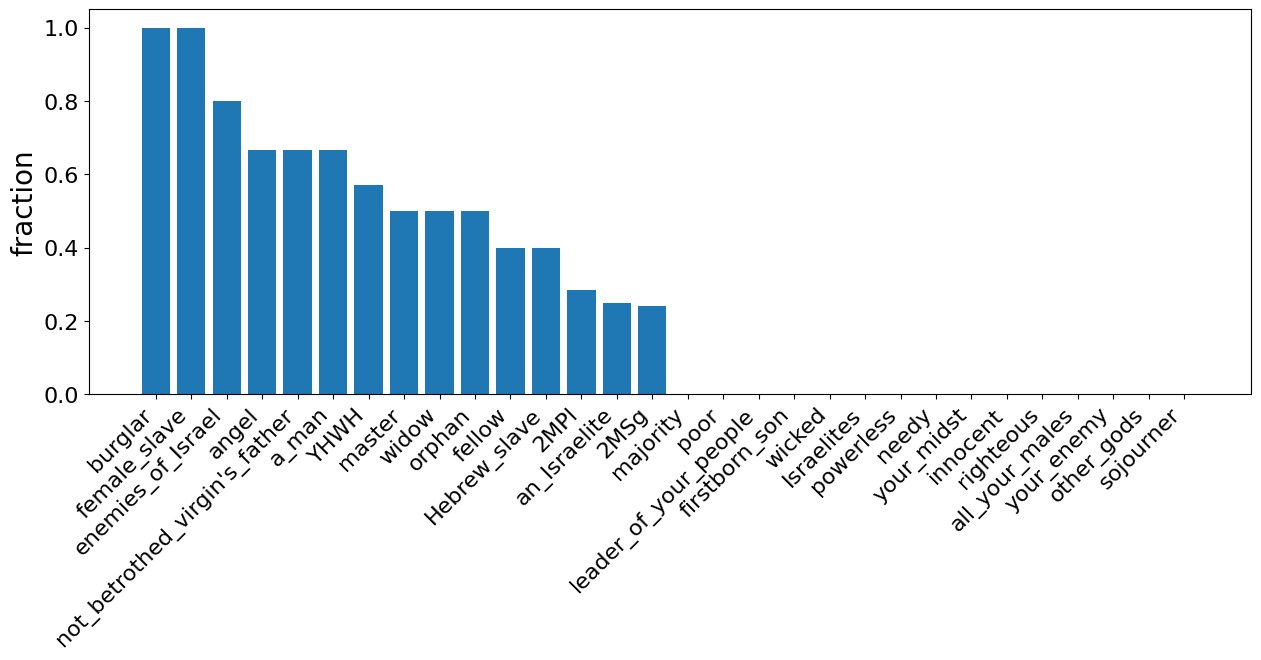

In [ ]:

fig, ax = plt.subplots(figsize=(15,5))

plt.bar(reci_df.index, reci_df[0])
plt.ylabel("fraction", size=20)
plt.xticks(size=16, rotation=45, ha='right')
plt.yticks(size=16)
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Reciprocity.png', dpi=500, bbox_inches='tight')
plt.show()

More close inspection:

In [ ]:
reci_df

,0
burglar,1.000000
female_slave,1.000000
enemies_of_Israel,0.800000
angel,0.666667
not_betrothed_virgin's_father,0.666667
a_man,0.666667
YHWH,0.571429
master,0.500000
widow,0.500000
orphan,0.500000


### Centrality

Preparing data:

In [ ]:
indegree = nx.in_degree_centrality(digraph)
outdegree = nx.out_degree_centrality(digraph)
betweenness = nx.betweenness_centrality(digraph)
pagerank = nx.pagerank(digraph)

Inspection of the data:

In [ ]:
centrality = pd.DataFrame([indegree, outdegree, betweenness, pagerank]).T
centrality.columns = ['indegree','outdegree','betweeness','pagerank']
centrality

,indegree,outdegree,betweeness,pagerank
YHWH,0.155556,0.311111,0.183838,0.112423
Moses,0.022222,0.022222,0.000000,0.017518
Israelites,0.088889,0.022222,0.007576,0.036766
2MPl,0.022222,0.133333,0.004545,0.017518
other_gods,0.044444,0.000000,0.000000,0.015050
2MSg,0.066667,0.488889,0.138889,0.048573
Hebrew_slave,0.044444,0.066667,0.050505,0.016508
master,0.044444,0.133333,0.033333,0.027807
Hebrew_slave's_wife,0.066667,0.000000,0.000000,0.028398
sons_or_daughters,0.000000,0.022222,0.000000,0.010692


#### Four metrics for measuring centrality

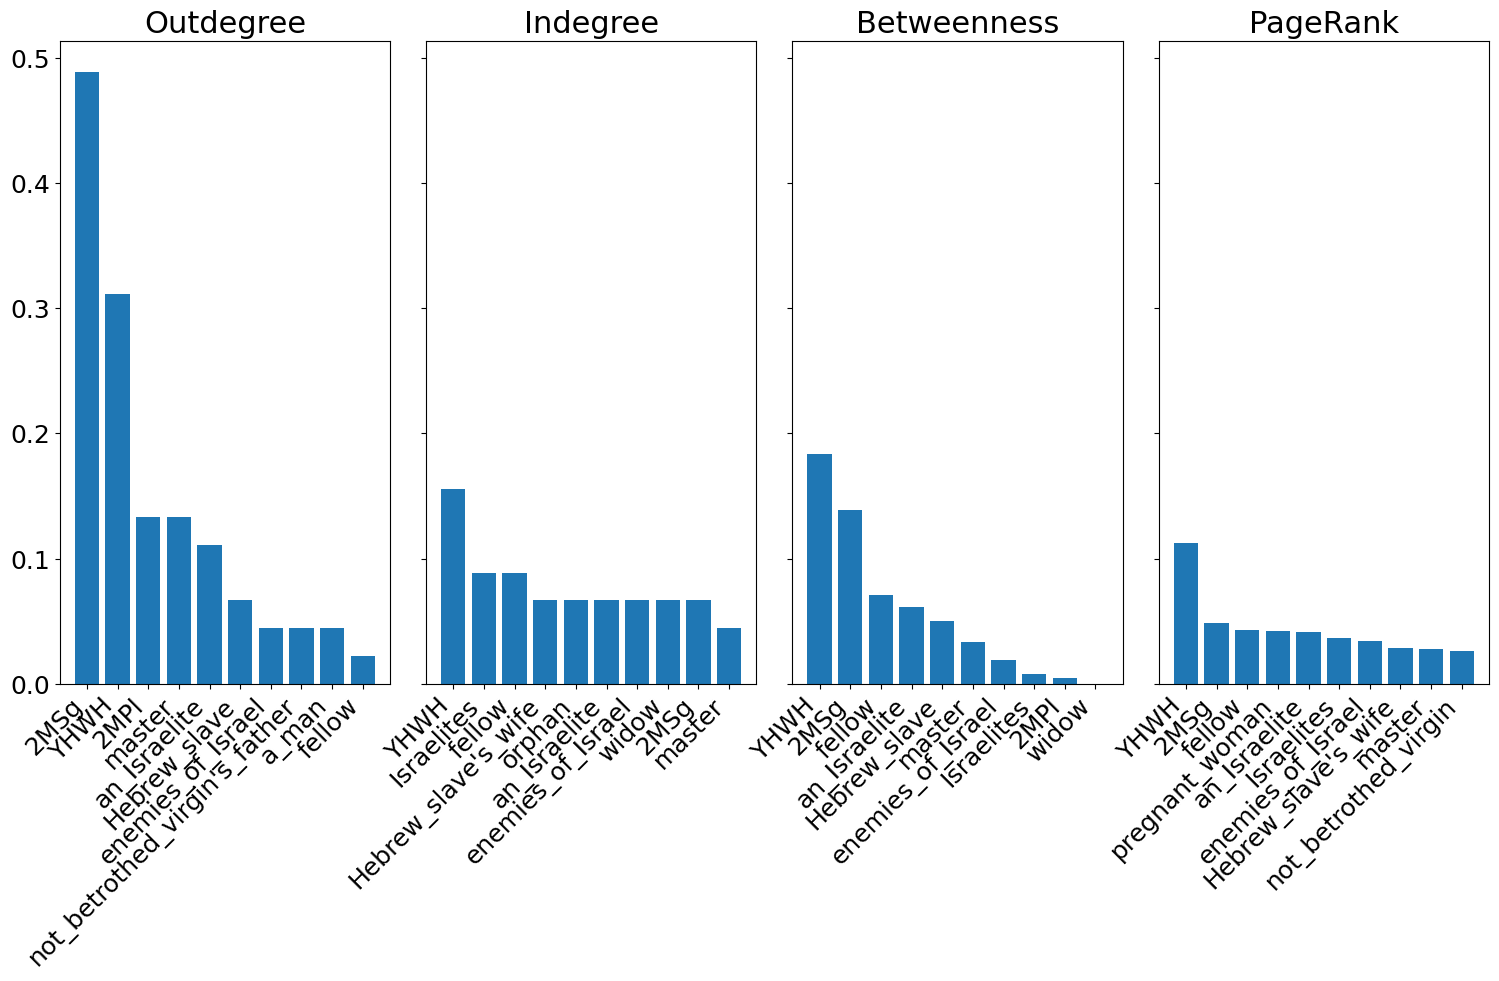

In [ ]:
def top(measure, df=centrality):
    return df.sort_values(by=measure, ascending=False)[measure][:10]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,7), sharey=True)
fig.tight_layout(pad=1.0)

ax1.bar(top('outdegree').index, top('outdegree'))
ax1.set_title("Outdegree", size=22)
ax2.bar(top('indegree').index, top('indegree'))
ax2.set_title("Indegree", size=22)
ax3.bar(top('betweeness').index, top('betweeness'))
ax3.set_title("Betweenness", size=22)
ax4.bar(top('pagerank').index, top('pagerank'))
ax4.set_title("PageRank", size=22)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', size=18)
    plt.yticks(size=18)
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Centrality.png', dpi=500, bbox_inches='tight')
plt.show()

#### Elimination test

In [ ]:
def removalTest(ego):
    
    density_dict = {}
    for n in ego.nodes():
        remove = [l for l in ego.nodes() if l!=n]
        new_graph = ego.subgraph(remove)
        density_dict[n] = nx.density(new_graph)

    removal_df = pd.DataFrame([density_dict]).T
    removal_df.columns=['density']
    return removal_df

removalTest(G)

,density
YHWH,0.048990
Moses,0.067677
Israelites,0.065152
2MPl,0.063636
other_gods,0.064141
2MSg,0.044444
Hebrew_slave,0.064646
master,0.057071
Hebrew_slave's_wife,0.067172
sons_or_daughters,0.068182


Original density of network: 0.06570048309178744


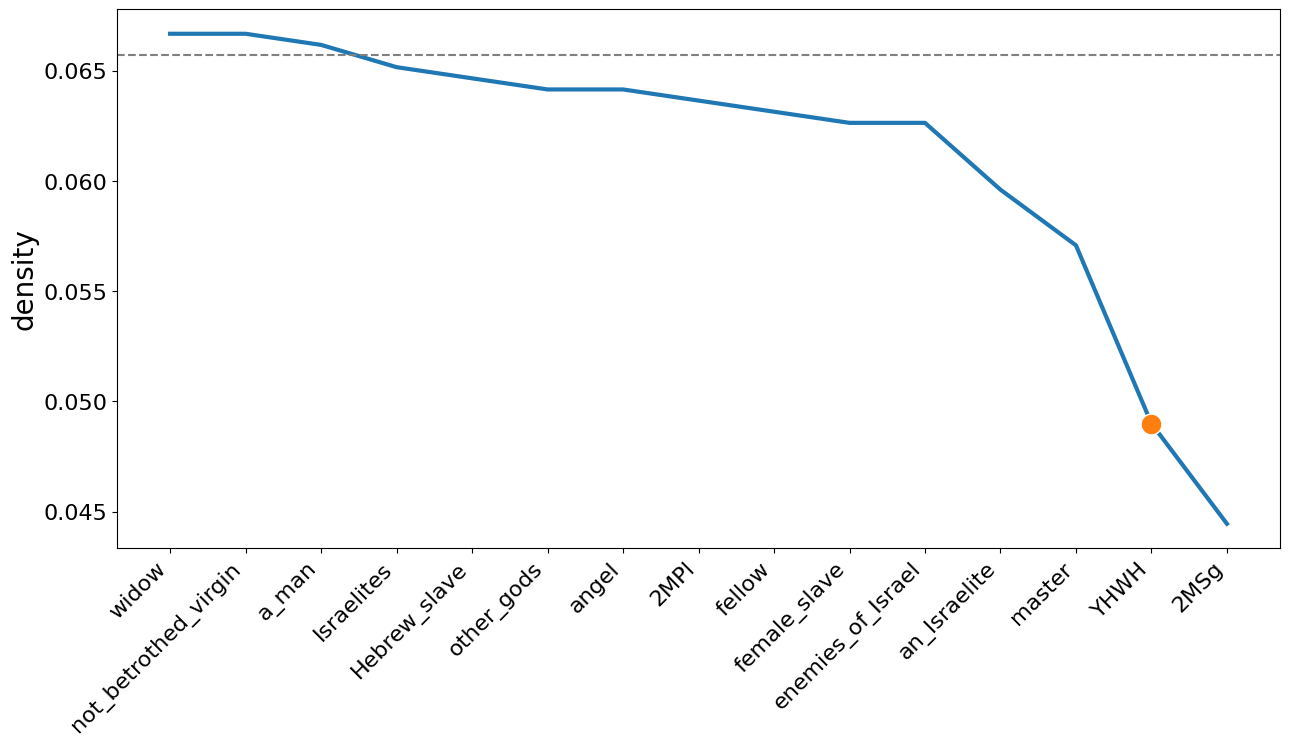

In [ ]:
def plotDF(graph, column, actor=str(), typ='ego', plot_graph=False, line=True, save=str()):
    '''
    It is possible to make a removal test for an ego-network (type='ego') and the entire graph ('graph')
    '''

    if typ == 'ego':
        ego = nx.ego_graph(graph, actor, undirected=True)
        df = removalTest(ego)
        df = df.sort_values(by=column, ascending=False).tail(15)
        ego_index = df.index.get_loc(actor)
        density = nx.density(ego)
        print(f'Original density of egonetwork: {density}')
 
    elif typ == 'graph':
        df = removalTest(graph)
        df = df.sort_values(by=column, ascending=False).tail(15)
        density = nx.density(graph)
        print(f'Original density of network: {density}')
    
    fig, ax = plt.subplots(figsize=(len(df),7))
    plot = plt.plot(df.index, df[column], linewidth=3)
    if actor:
        actor_x = df.index.get_loc(actor)
        actor_y = df[df.index == actor].density.item()
        plt.plot([actor_x], [actor_y], marker="o", markeredgecolor="white", markersize=15)
    plt.ylabel("density", size=20)
    plt.xticks(size=16, rotation=45, ha='right')
    plt.yticks(size=16)
    
    if line:
        plt.axhline(y=density, linestyle='dashed', color='grey')
    
    # draw graph in inset
    if plot_graph:
        plt.axes([0.4, 0.4, 0.5, 0.5])
        nodes = list(df.index)

        subgraph = graph.subgraph(nodes)
        pos = nx.spring_layout(subgraph)
        nx.draw(
            subgraph,
            pos=pos,
            with_labels=True,
            edge_color='grey',
            node_color='lightblue',
            font_size=14
            )
        nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[ego], node_color='salmon')

        plt.axis('off')
        plt.grid(True)
    if save:   
        plt.savefig(fname=f'Pictures_Ex_20.22-23.33/{save}', bbox_inches='tight', dpi=500)

plotDF(G, actor="YHWH", column='density', typ='graph', line=True, save='Elimination_test')

### Clustering

#### Ward algorithm

In [ ]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source, row.Target, value=row.Weight)
nodes = list(G.nodes())
matrix = nx.to_numpy_matrix(G)
df = pd.DataFrame(matrix, columns=nodes, index=nodes)
linked = linkage(matrix, 'single')

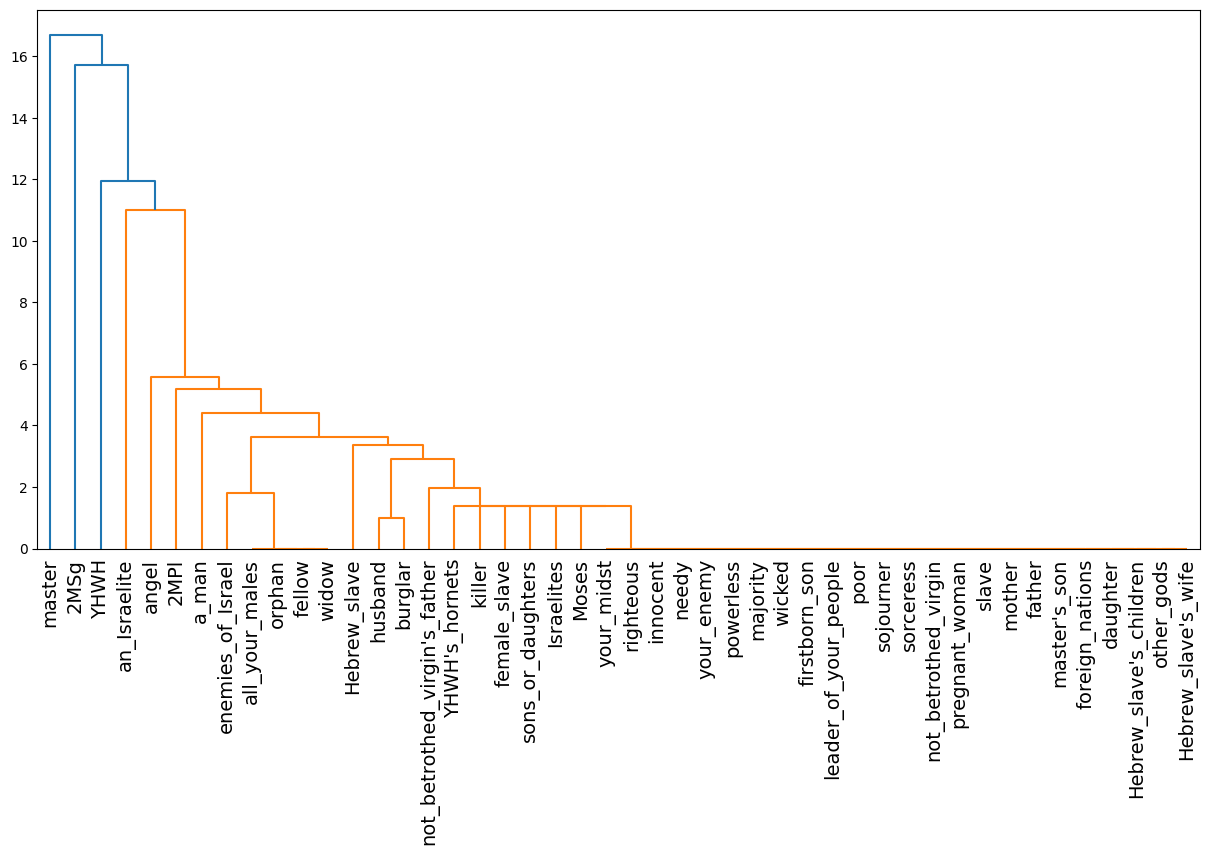

In [ ]:
plt.figure(figsize=(15, 7))
dend = shc.dendrogram(shc.linkage(matrix, method='ward'), labels=nodes, leaf_font_size=14)
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Dendrogram.png', dpi=500, bbox_inches='tight')

#### MDS

d:\Python_thingies\envs\graph\lib\site-packages\sklearn\manifold\_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


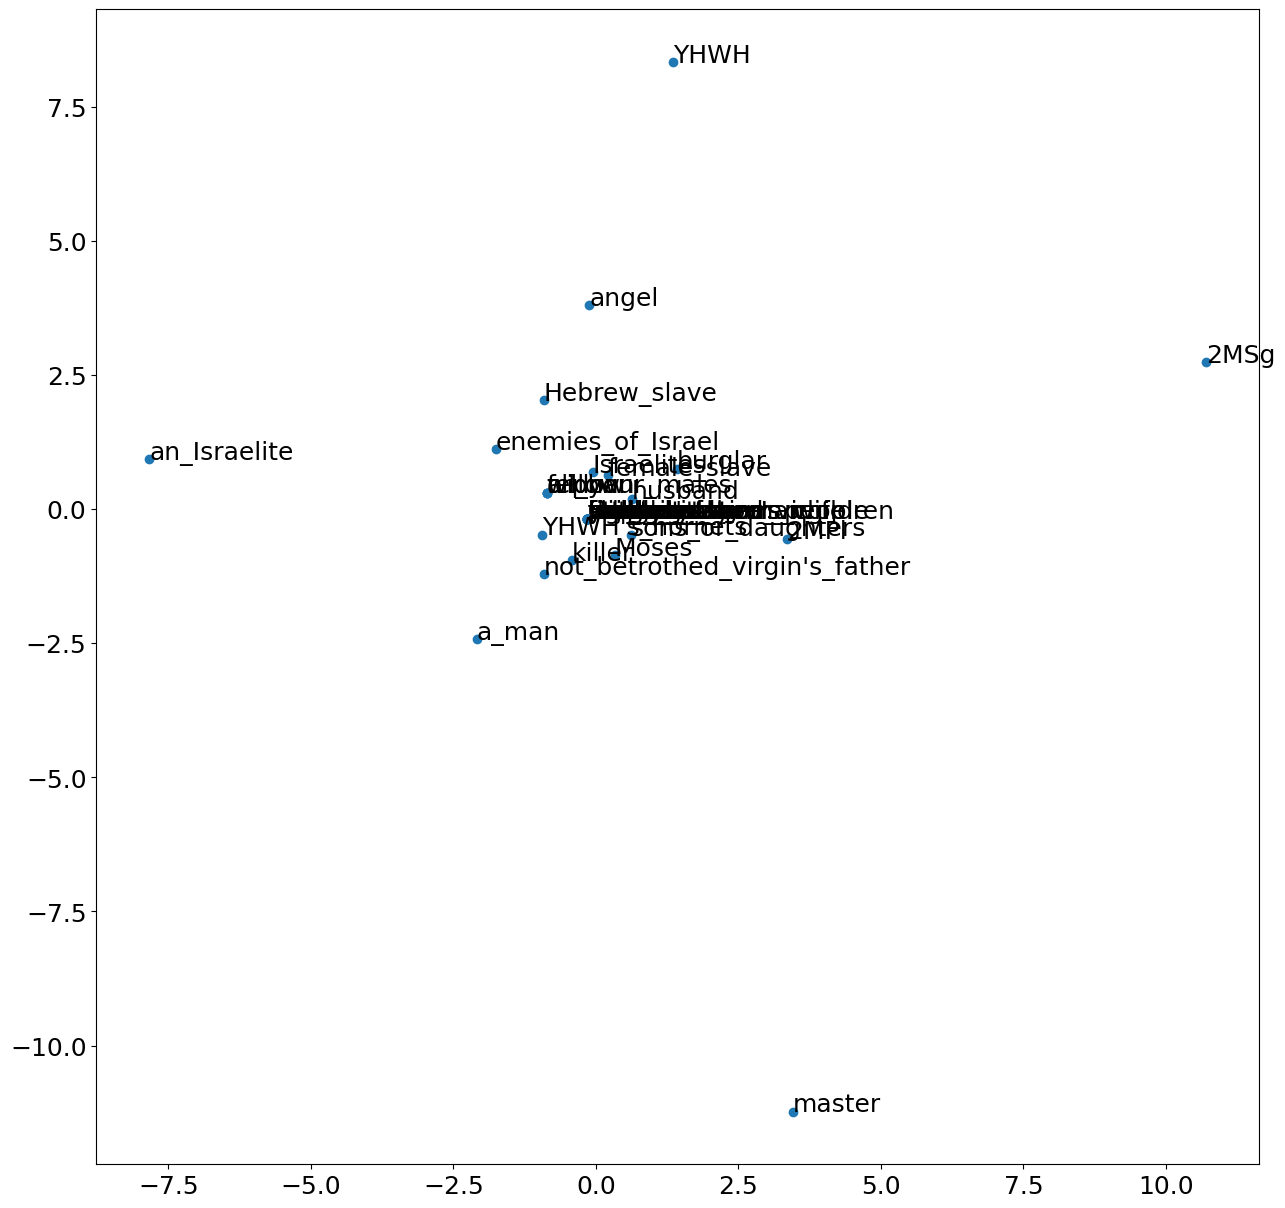

In [ ]:
embedding = MDS(n_components=2)

X_transformed = embedding.fit_transform(df)
X_transformed.shape

X = pd.DataFrame(X_transformed, index=nodes)

plt.figure(figsize=(15,15))
plt.scatter(X.iloc[:,0],X.iloc[:,1])

for n, row in X.iterrows():
    plt.text(row[0],row[1],n, size=18)

plt.xticks(size=18)
plt.yticks(size=18)
plt.savefig(fname=f'Pictures_Ex_20.22-23.33/MDS.png', dpi=500, bbox_inches='tight')
plt.show()

### Node2Vec

#### Multiple directed graph (weighted by average agency values)

In [ ]:
# Global data
dim = 16
wl = 4
nw = 150
p=1
q=1

In [ ]:
def getEmbeddings(file, nodes):
    with open(file) as f:
        mylist = [line.rstrip('\n') for line in f]

    embeddings_dict = collections.defaultdict()
    for l in mylist[1:]:
        vector = l.split()
        embeddings_dict[vector[0]] = vector[1:]

    
    embeddings = [embeddings_dict[str(n)] for n in nodes]
    embeddings = np.array(embeddings)
    return embeddings

In [ ]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source, row.Target, value=row.Weight)
    
nodes = list(G.nodes())

In [ ]:
node2vec = Node2Vec(G, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q, weight_key='value')

Computing transition probabilities:   0%|          | 0/46 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 150/150 [00:00<00:00, 2830.14it/s]


In [ ]:
model = node2vec.fit(window=6, min_count=1)

In [ ]:
model.wv.save_word2vec_format('node2vec/multiple_valued_directed')

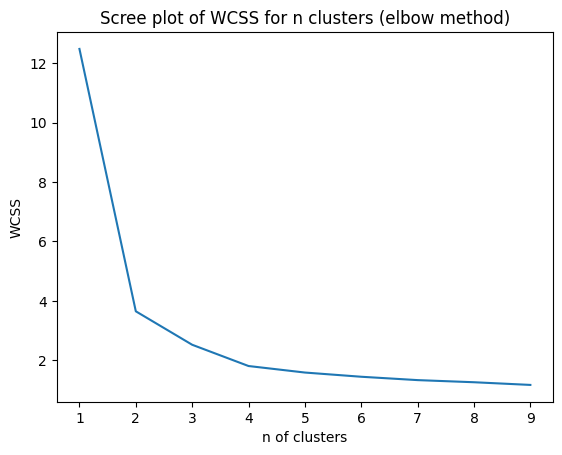

In [ ]:
X = getEmbeddings('node2vec/multiple_valued_directed', G.nodes())

def elbow(X,max_clusters=10):

    wcss = [] #for storing the intertia property

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Scree plot of WCSS for n clusters (elbow method)')
    plt.xlabel('n of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
elbow(X)

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

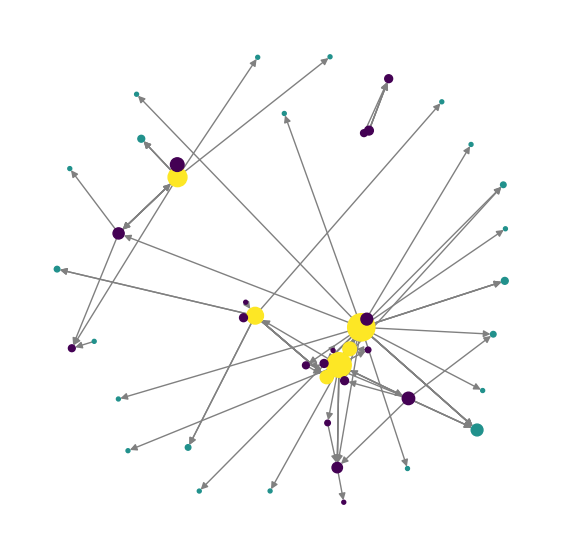

In [ ]:
def draw(graph, X, kmeans, labels=True, size=(15,15)):

    plt.figure(figsize = size)
    
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=labels,
        node_size=[n[1]*8 for n in G.degree()],
        node_color=kmeans.labels_,
        edge_color='grey'
        )
    
    plt.axis('off')
    plt.show()

draw(G, X, kmeans, labels=False, size=(7,7))
    

In [ ]:
def mds(graph, X, kmeans, n_components=2, label=True, size=(7, 7), save=str()):
    
    X = pd.DataFrame(X) if isinstance(X, (pd.Series, list)) else X
    X = np.array(X, dtype=np.float32)
    X = np.nan_to_num(X)

   
    embedding = MDS(n_components=n_components)
    X_transformed = embedding.fit_transform(X)
    X = pd.DataFrame(X_transformed, index=graph.nodes)

    
    plt.figure(figsize=size)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_)

    if label:
        for n, row in X.iterrows():
            plt.text(row[0], row[1], n, size=18)

    plt.xticks(size=18)
    plt.yticks(size=18)

    plt.savefig(fname=f'Pictures_Ex_20.22-23.33/Node2Vec.png', dpi=500, bbox_inches='tight')
    plt.show()


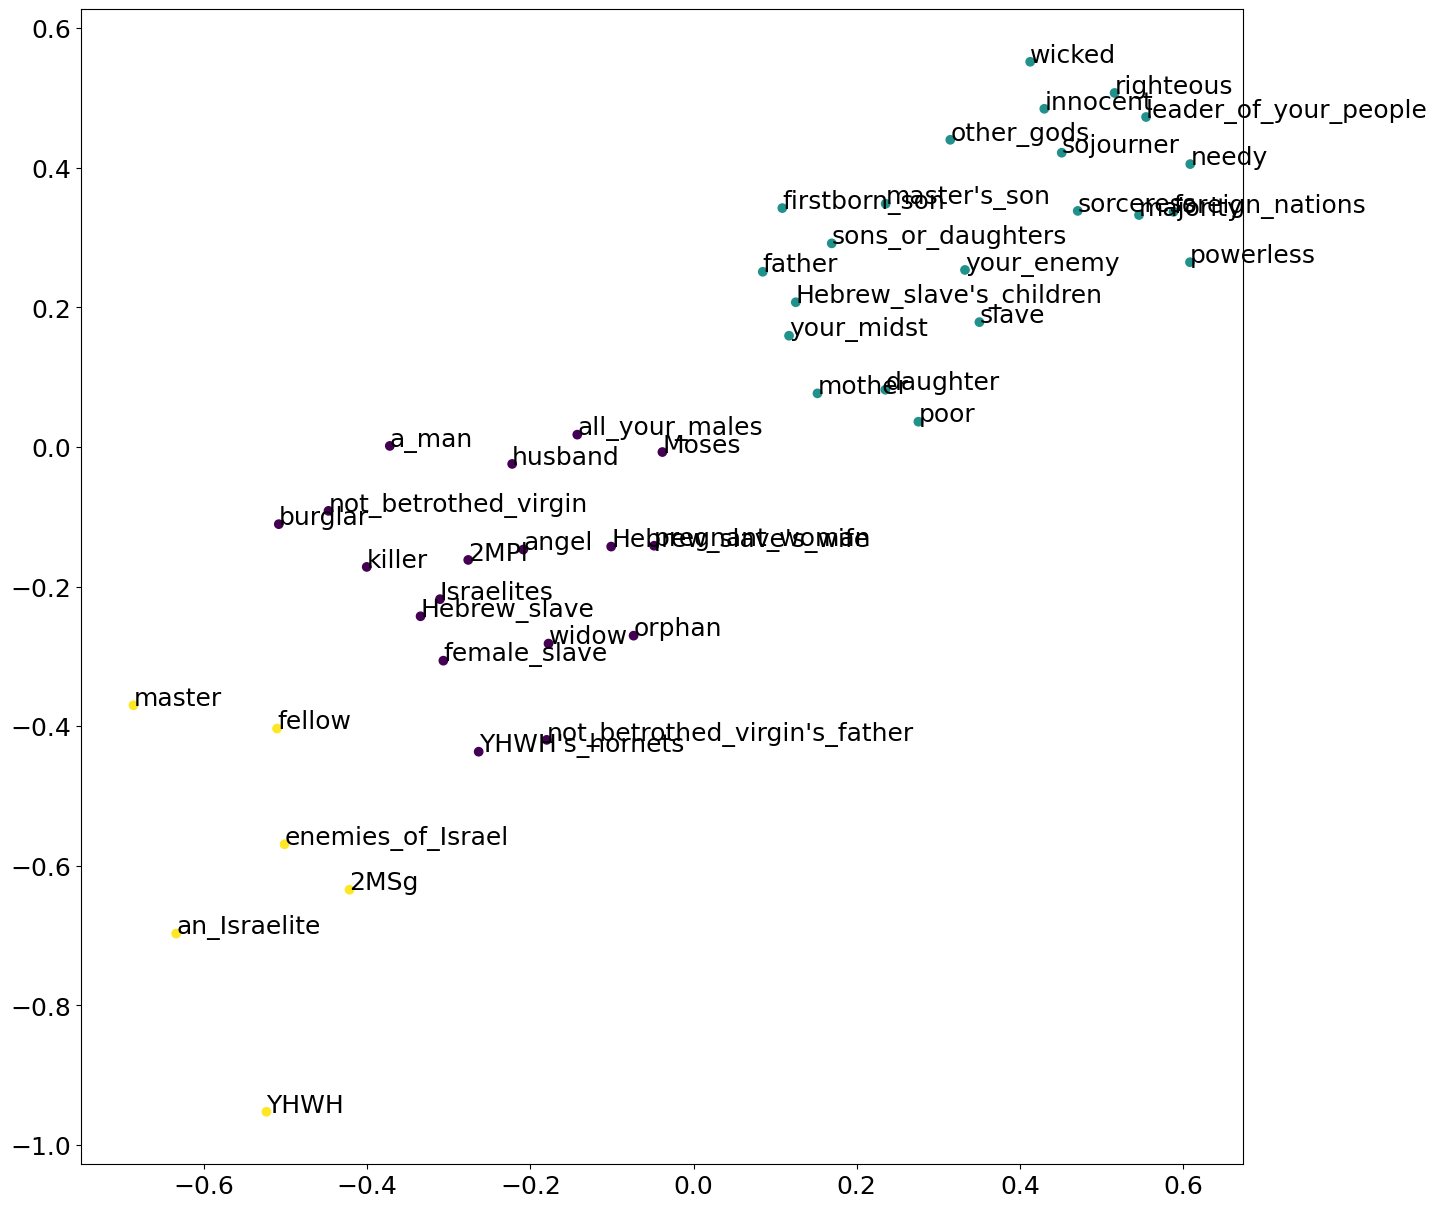

In [ ]:
mds(G, X, kmeans, size=(15,15))
